<a href="https://colab.research.google.com/github/Twisterrr/Time-Series-Analysis-Project/blob/main/Seasonal_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Time Series Analysis Project**


## Seasonal Time Series Analysis

---



> D22125067 Clement BERARD

> D22125152 Sephora Panchbaya


---






### **Summary**
*   Dataset name : Climate Change - Earth Surface Temperature Data
*   Dataset source : https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv
*   1- Goal of the project 
*   2- Background of the data
*   3- Data preprocessing
*   4- Plotting the time series
*   5- Checking stationnarity
*   6- Plotting ACF and PACF
*   7- Defining the model
*   8- Residuals Analysis
*   9- Testing
*   10- Forecasting
*   Conclusion
-------------------------------------------------------------------------

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import ceil
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

## **Part 2 : Seasonal Time Series Analysis**

For this Time Series Analysis, we decided to work on climate change data in the world in order to work on Seasonal data. 
Indeed, these data are concentrated on a period from 1750 to 2015 based on data of Land Average Temperature, Land Average Temperature Uncertainty temperatures, Land And Ocean Average Temperature …

### 1- Goal
The goal of the project is to see the effect of climate change around the world through the average global temperatures each month on land.

### 2- Background of the data : 

Early data was collected by technicians using mercury thermometers, where any variation in the visit time impacted measurements. In the 1940s, the construction of airports caused many weather stations to be moved. In the 1980s, there was a move to electronic thermometers that are said to have a cooling bias.


### 3- Data Preprocessing
In order to do this we have made some changes to the dataset. First, we removed the columns that will not be used.

In [3]:
df_two = pd.read_csv('https://raw.githubusercontent.com/Twisterrr/tu-assignment/main/GlobalTemperatures.csv', usecols = ['dt', 'LandAverageTemperature']) #keeping only the date and data columns we will use
df_two = df_two.tail(ceil((len(df_two) / 20))) #splitting the dataset in 20 and keeping the most recent values
df_two.head() #print the first 5 data of the dataset

dt  LandAverageTemperature
3032  2002-09-01                  12.950
3033  2002-10-01                   9.988
3034  2002-11-01                   6.892
3035  2002-12-01                   4.038
3036  2003-01-01                   3.981

We can see the first 5 data of the dataset.

### 4- Plotting the time series

Next, I will plot my chart but before that I need to convert my "date" column to a correct format so I can use them for the best.

              dt  LandAverageTemperature
3032  2002-09-01                  12.950
3033  2002-10-01                   9.988
3034  2002-11-01                   6.892
3035  2002-12-01                   4.038
3036  2003-01-01                   3.981
...          ...                     ...
3187  2015-08-01                  14.755
3188  2015-09-01                  12.999
3189  2015-10-01                  10.801
3190  2015-11-01                   7.433
3191  2015-12-01                   5.518

[160 rows x 2 columns]


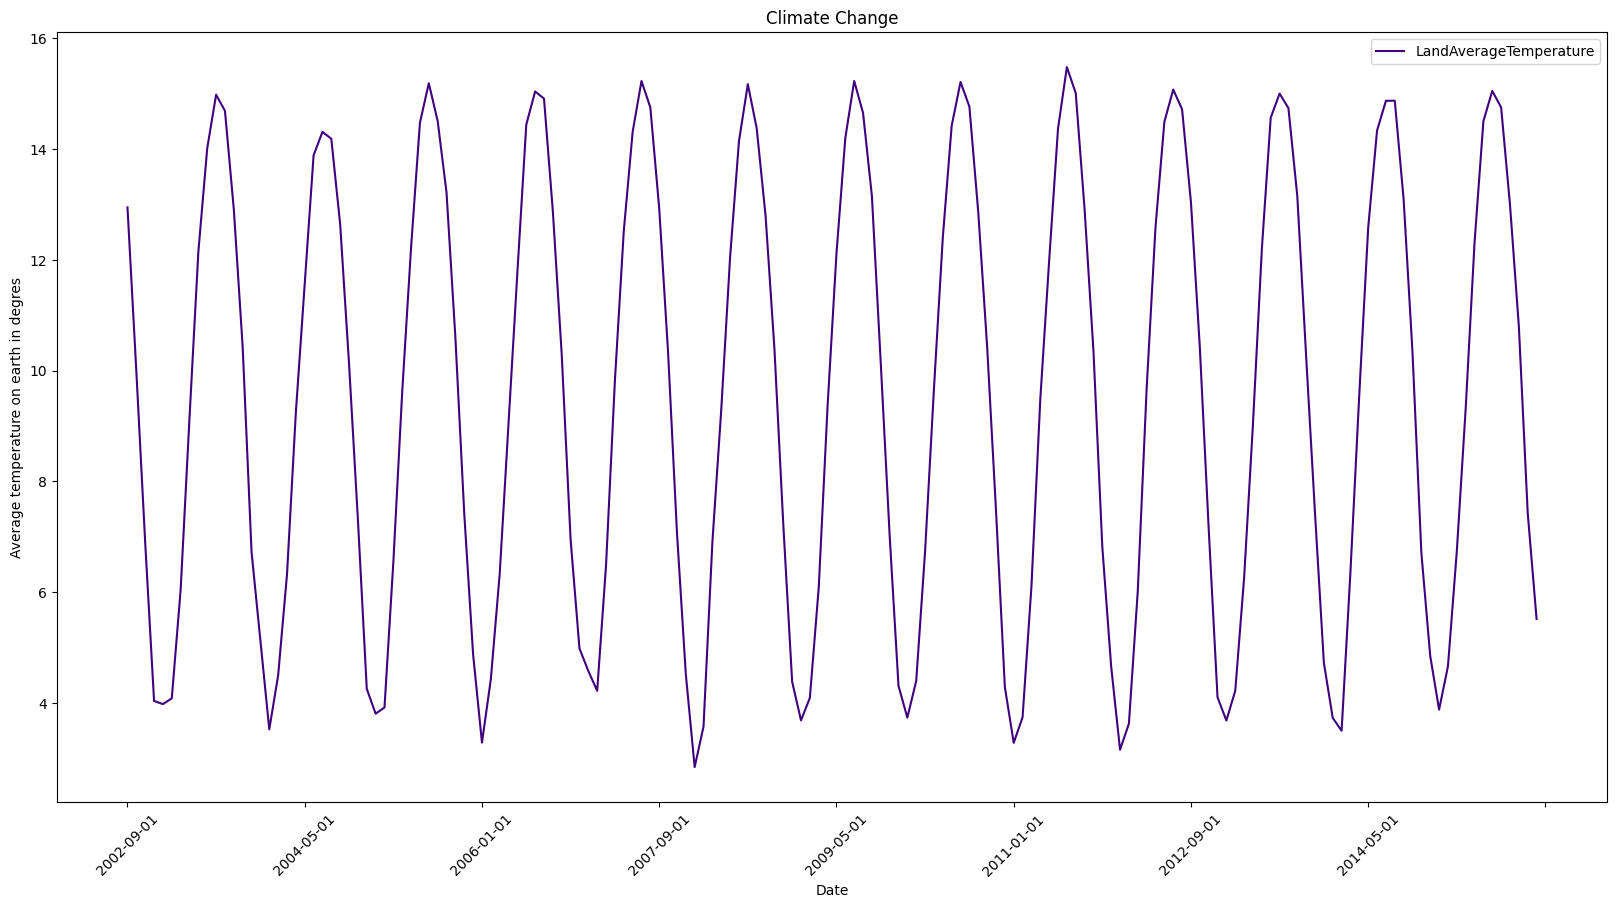

In [4]:
ax = df_two.plot(x= 'dt', y = 'LandAverageTemperature', colormap='Purples_r', title='Climate Change', rot=45, figsize=(20,10)) #create my plot 
ax.set_xlabel("Date") #label name for X
ax.set_ylabel("Average temperature on earth in degres") #label name for Y
print(df_two) #printing my dataset

We can find a pattern that repeats itself in the annual temperatures in the world according to the seasons/months of the year.

### 5- Checking stationnarity
We can clearly see an increasing trend in our datas so we can suppose that they are non-stationnary. We can check this hypothesis with the ADF test.

*   ADF Test - 1



In [5]:
# Perform the ADF test on the 'Sunshine' column of the 'London Weather' dataframe
sunshine_df = df_two
ADF_result_two = adfuller(sunshine_df['LandAverageTemperature'])

print(f'ADF Statistic: {ADF_result_two[0]}')
print(f'p-value: {ADF_result_two[1]}')
for key, value in ADF_result_two[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -2.4808209473168734
p-value: 0.12021080373357884
Critial Values:
   1%, -3.476273058920005
Critial Values:
   5%, -2.881687616548444
Critial Values:
   10%, -2.5775132580261593


With the ADF test, we obtain that the ADF statistic is higher than any of the critical values and that the p-value is greater than 0.05. So this time series is non-stationary and we  have to apply transformations to make it stationary.

*   Applying the first transformation



The data we currently have is non-stationary, meaning that it has trends and patterns that vary over time. In order to do this, we will apply a first order differentiation to the data. This involves subtracting each observation from the previous one to eliminate the time trend and make the data more stable and less subject to fluctuations.

In [6]:
sunshine_diff = np.diff(sunshine_df['LandAverageTemperature'], n=1)
date_array_two = sunshine_df['dt'].values
date_array_two = date_array_two[1:]
print(sunshine_diff)

[-2.962e+00 -3.096e+00 -2.854e+00 -5.700e-02  1.040e-01  1.963e+00
  3.106e+00  2.999e+00  1.864e+00  9.660e-01 -2.920e-01 -1.780e+00
 -2.487e+00 -3.697e+00 -1.594e+00 -1.608e+00  9.740e-01  1.822e+00
  2.928e+00  2.322e+00  2.318e+00  4.230e-01 -1.240e-01 -1.546e+00
 -2.515e+00 -2.812e+00 -3.058e+00 -4.490e-01  1.120e-01  2.624e+00
  3.074e+00  2.608e+00  2.250e+00  7.140e-01 -6.800e-01 -1.293e+00
 -2.616e+00 -3.178e+00 -2.545e+00 -1.592e+00  1.144e+00  1.899e+00
  2.726e+00  2.731e+00  2.657e+00  5.990e-01 -1.290e-01 -2.038e+00
 -2.586e+00 -3.334e+00 -1.968e+00 -4.080e-01 -3.580e-01  2.264e+00
  3.338e+00  2.695e+00  1.791e+00  9.210e-01 -4.780e-01 -1.822e+00
 -2.598e+00 -3.248e+00 -2.561e+00 -1.679e+00  7.320e-01  3.330e+00
  2.389e+00  2.759e+00  2.091e+00  1.029e+00 -7.970e-01 -1.575e+00
 -2.403e+00 -3.175e+00 -2.839e+00 -6.980e-01  4.070e-01  1.992e+00
  3.281e+00  2.745e+00  2.089e+00  1.030e+00 -5.760e-01 -1.502e+00
 -3.017e+00 -3.105e+00 -2.721e+00 -5.730e-01  6.620e-01  2.339

Let's plot our new dataframe and original one.

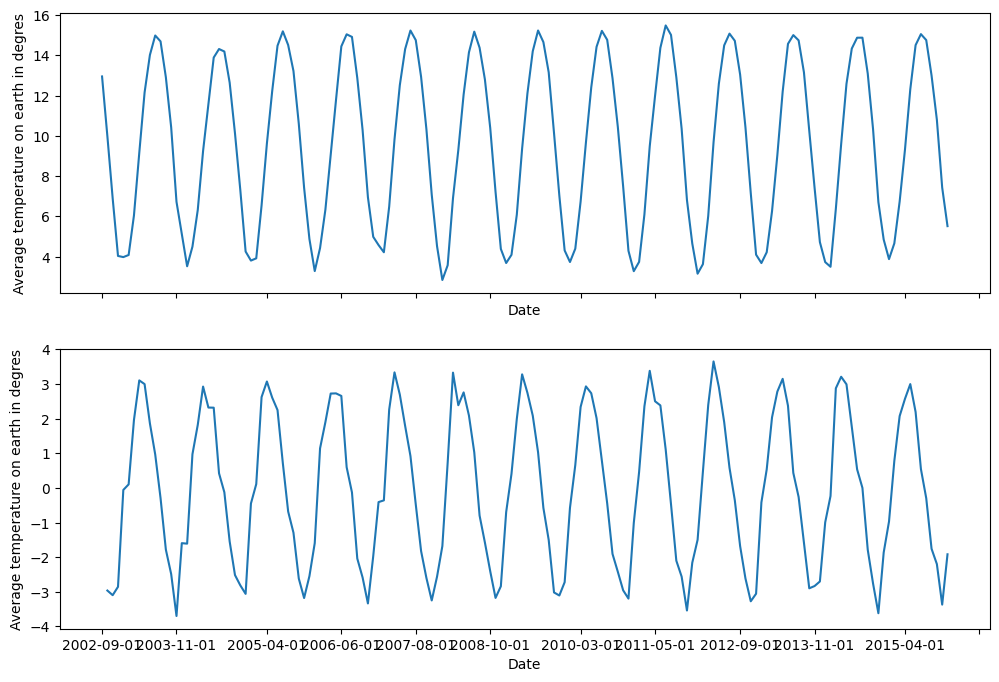

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,8))

ax1.plot(sunshine_df['dt'], sunshine_df['LandAverageTemperature'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Average temperature on earth in degres')

ax2.plot(date_array_two, sunshine_diff)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average temperature on earth in degres')

num_ticks = 8
locator = mdates.AutoDateLocator(minticks=num_ticks, maxticks=num_ticks)
ax1.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_locator(locator)



*   ADF Test - 2



In [8]:
ADF_result_two = adfuller(sunshine_diff)

print(f'ADF Statistic: {ADF_result_two[0]}')
print(f'p-value: {ADF_result_two[1]}')
for key, value in ADF_result_two[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -4.949023290160842
p-value: 2.7969667115466126e-05
Critial Values:
   1%, -3.476273058920005
Critial Values:
   5%, -2.881687616548444
Critial Values:
   10%, -2.5775132580261593


With the ADF test, we obtain that the ADF statistic is lower than any of the critical values and that the p-value is lower then 0.05. The null hypothesis is now rejected and the serie is now stationary.



### 6- Plotting ACF and PACF

Now that our datas are stationnary, we can plot the ACF and PACF and see if we can identify the model of our datas from it.

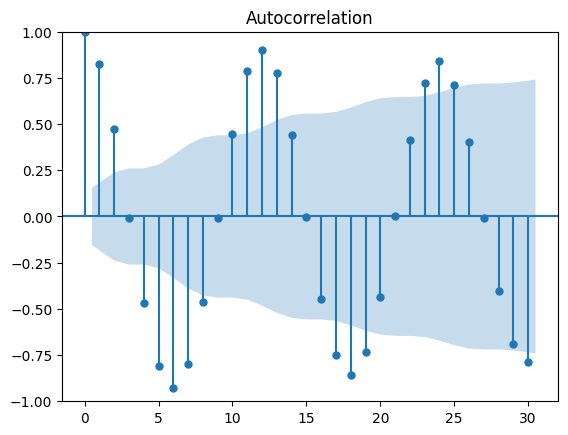

In [9]:
plot_acf(sunshine_diff, lags=30);

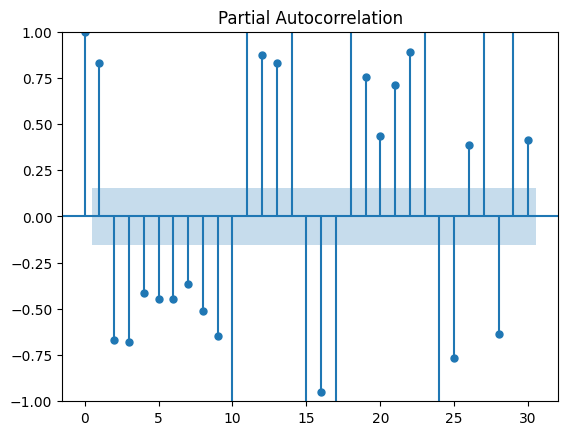

In [10]:
plot_pacf(sunshine_diff, lags=30);

After analyzing the two corelations of the ACF and PACF, we finally have an **ARMA** process model.

### 7- Defining the model

To fit the many SARIMA(p,d,q)(P,D,Q)m models, we’ll define the optimize_ARIMA and optimize_SARIMA function. It will fit the different models and order them by ascending AIC in order to select the model with the lowest AIC.

In [11]:
def optimize_ARIMA(training_data, order_list, d) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(training_data, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        bic= model.bic
        results.append([order, aic, bic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC','BIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df 

In [12]:
def optimize_SARIMA(train, order_list, d, D, s) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                train, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

We then define a list of possible values for the orders p and q with the Arima Order List.

In [13]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

df_two['dt'] = pd.to_datetime(df_two['dt'], format='%Y-%m-%d')
df_two.set_index('dt', inplace=True) 


train_arima = df_two['LandAverageTemperature'][0:160]

ARIMA_result_df = optimize_SARIMA(train_arima, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

(p,q,P,Q)         AIC
0     (12, 9, 0, 0)  143.168134
1    (12, 11, 0, 0)  144.143601
2    (10, 12, 0, 0)  145.420186
3     (10, 9, 0, 0)  145.621438
4      (2, 7, 0, 0)  145.778618
..              ...         ...
164    (1, 1, 0, 0)  479.312418
165    (1, 2, 0, 0)  487.614261
166    (0, 3, 0, 0)  494.438144
167    (0, 1, 0, 0)  499.252508
168    (0, 0, 0, 0)  525.317290

[169 rows x 2 columns]

Then, we define a list of possible values for the orders p, q, P and Q with the Sarima Order List.

In [14]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train_sarima = df_two['LandAverageTemperature'][0:160]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train_sarima, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q,P,Q)         AIC
0    (1, 1, 0, 3)   81.595183
1    (1, 3, 0, 3)   81.783218
2    (1, 1, 1, 1)   82.254697
3    (0, 3, 0, 3)   82.363417
4    (1, 3, 2, 1)   82.451531
..            ...         ...
251  (3, 2, 0, 0)  188.960628
252  (3, 0, 0, 0)  199.633112
253  (2, 0, 0, 0)  216.613326
254  (1, 0, 0, 0)  224.888400
255  (0, 0, 0, 0)  251.498391

[256 rows x 2 columns]

In [15]:
ARIMA_model = SARIMAX(train_arima, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     LandAverageTemperature   No. Observations:                  160
Model:                  SARIMAX(11, 2, 3)   Log Likelihood                 -70.580
Date:                    Mon, 08 May 2023   AIC                            171.160
Time:                            18:24:04   BIC                            217.099
Sample:                        09-01-2002   HQIC                           189.816
                             - 12-01-2015                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3369      0.661     -2.024      0.043      -2.632      -0.042
ar.L2         -0.9547      0.444     -2.148      0.032      -1.826      -0.084
ar.L3         -0.757

In [20]:
SARIMA_model = SARIMAX(train_sarima, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                  LandAverageTemperature   No. Observations:                  160
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                 -35.398
Date:                                 Mon, 08 May 2023   AIC                             84.796
Time:                                         18:24:10   BIC                            105.729
Sample:                                     09-01-2002   HQIC                            93.301
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2892      0.084      3.431      0.001       0.124       0

### 8- Residuals Analysis

Now that we have defined a model, we can try and fit it to our training data and display the residuals’ diagnostics. 
For the ARIMA model :

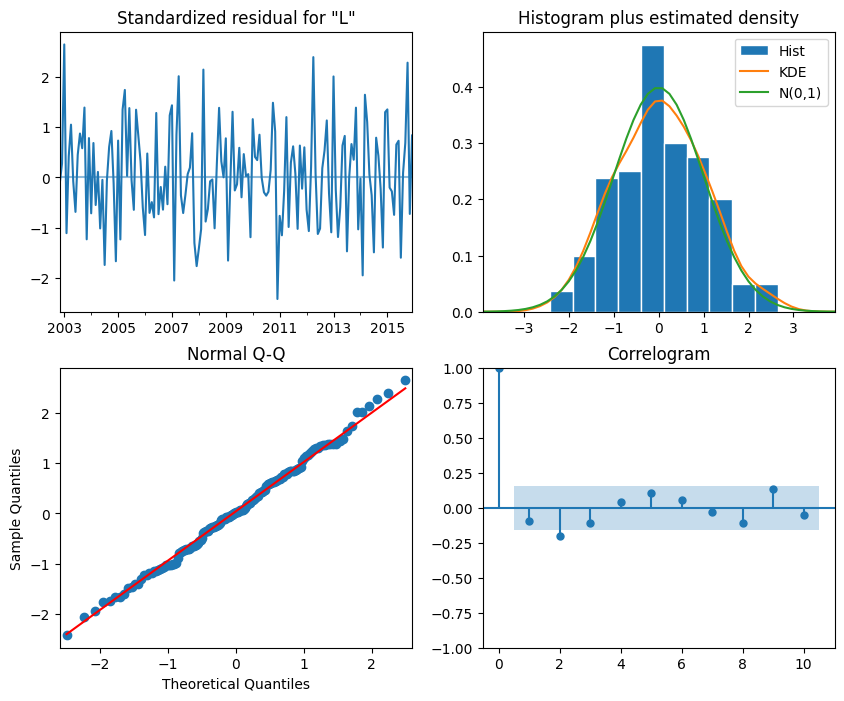

In [16]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

- In the top-left plot, the residuals have
no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. 
- The histogram shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak.
- The Q-Q shows us a line that is fairly straight, meaning that the residuals’s distribution is close to a normal distribution.
- On the correlogram, shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise.
But lets continue with this model to see if can do something.

Then for the SAMIRA model :

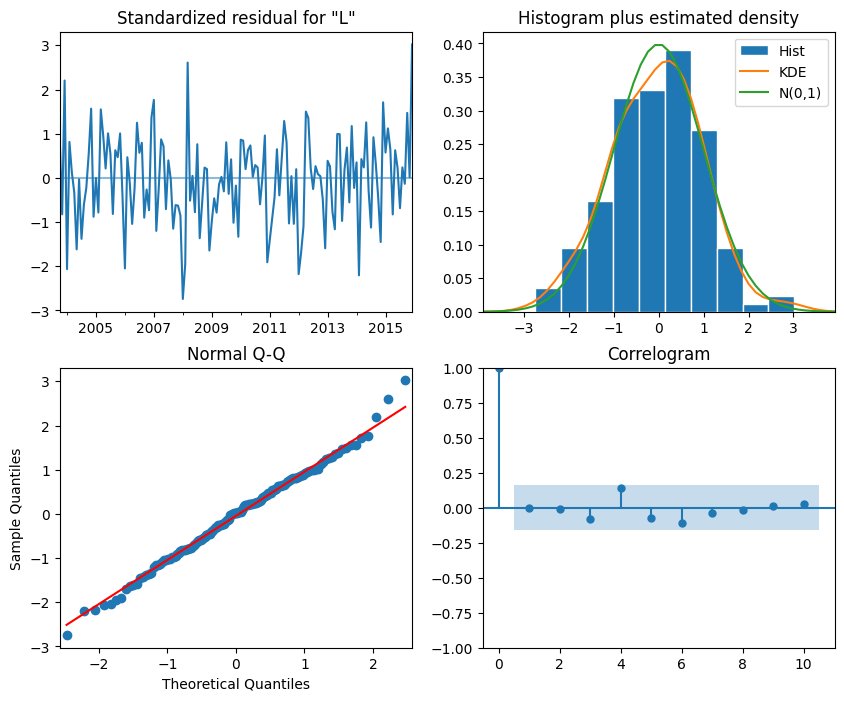

In [21]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

- In the top-left plot, the residuals have
no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. 
- The histogram shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak.
- The Q-Q shows us a line that is fairly straight, meaning that the residuals’s distribution is close to a normal distribution.
- On the correlogram, shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise.
But lets continue with this model to see if can do something.

Let's apply the Ljung-Box test to determine if the residuals are correlated.

First for the ARIMA model :

In [17]:
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat     lb_pvalue
1   31.018866  2.555324e-08
2   31.202296  1.676901e-07
3   32.216647  4.711147e-07
4   36.755313  2.022956e-07
5   37.316094  5.176095e-07
6   37.321149  1.524403e-06
7   37.595710  3.616354e-06
8   37.600330  8.922137e-06
9   37.643276  2.019611e-05
10  37.664913  4.340114e-05

Then for the SAMIRA model :

In [22]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_stat  lb_pvalue
1    0.000038   0.995091
2    0.790894   0.673379
3    7.584287   0.055432
4    9.106292   0.058497
5   13.868155   0.016469
6   14.274497   0.026716
7   15.317014   0.032144
8   18.014383   0.021119
9   21.950050   0.009039
10  25.144883   0.005078

Every lb_pvalue that we have is lesser then 0.05 so we can reject the null hypothesis, meaning that our residuals are correlated.

Our model does not pass the Ljungbox test but we will keep going to see what we can do.

### 9- Testing

Let's first defining a testing dataset and do some naive predictions on it.

In [18]:
test = df_two.iloc[-12:]

test['naive_seasonal'] = df_two['LandAverageTemperature'].iloc[120:132].values
test

LandAverageTemperature  naive_seasonal
dt                                                
2015-01-01                   3.881          13.040
2015-02-01                   4.664          10.428
2015-03-01                   6.740           7.156
2015-04-01                   9.313           4.102
2015-05-01                  12.312           3.685
2015-06-01                  14.505           4.222
2015-07-01                  15.051           6.261
2015-08-01                  14.755           9.044
2015-09-01                  12.999          12.195
2015-10-01                  10.801          14.568
2015-11-01                   7.433          15.003
2015-12-01                   5.518          14.742

Then, for the ARIMA model prediction :



In [19]:
ARIMA_pred = ARIMA_model_fit.get_prediction('2015-01-01', '2015-12-01').predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

LandAverageTemperature  naive_seasonal  ARIMA_pred
dt                                                            
2015-01-01                   3.881          13.040    3.388399
2015-02-01                   4.664          10.428    4.737332
2015-03-01                   6.740           7.156    6.840913
2015-04-01                   9.313           4.102    9.583614
2015-05-01                  12.312           3.685   12.073761
2015-06-01                  14.505           4.222   14.239298
2015-07-01                  15.051           6.261   15.631740
2015-08-01                  14.755           9.044   14.722132
2015-09-01                  12.999          12.195   12.747687
2015-10-01                  10.801          14.568    9.970152
2015-11-01                   7.433          15.003    7.696929
2015-12-01                   5.518          14.742    5.213901

Finally, for the SARIMA model prediction :

In [23]:
SARIMA_pred = SARIMA_model_fit.get_prediction('2015-01-01', '2015-12-01').predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

LandAverageTemperature  naive_seasonal  ARIMA_pred  SARIMA_pred
dt                                                                         
2015-01-01                   3.881          13.040    3.388399     3.720547
2015-02-01                   4.664          10.428    4.737332     4.350866
2015-03-01                   6.740           7.156    6.840913     6.559383
2015-04-01                   9.313           4.102    9.583614     9.544215
2015-05-01                  12.312           3.685   12.073761    12.137044
2015-06-01                  14.505           4.222   14.239298    14.442923
2015-07-01                  15.051           6.261   15.631740    15.242676
2015-08-01                  14.755           9.044   14.722132    14.688534
2015-09-01                  12.999          12.195   12.747687    13.036153
2015-10-01                  10.801          14.568    9.970152    10.390927
2015-11-01                   7.433          15.003    7.696929     7.428921
2015-12-01                   5.518          14.742    5.213901     4.676428

Now, let's try to apply our model on the testing dataset.

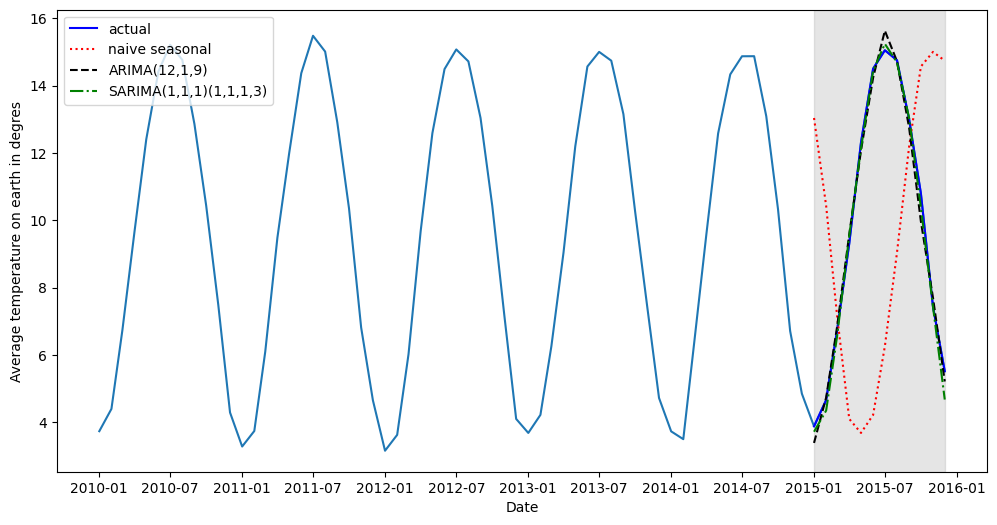

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
df_two = df_two.loc[df_two.index >= '2010']
ax.plot(df_two.index, df_two['LandAverageTemperature'])
ax.plot(test['LandAverageTemperature'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(12,1,9)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,1,1)(1,1,1,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Average temperature on earth in degres')
ax.axvspan('2015-01-01', '2015-12-01', color='#808080', alpha=0.2)

ax.legend(loc=2)

num_ticks = 8
locator = mdates.AutoDateLocator(minticks=num_ticks, maxticks=num_ticks)
ax.xaxis.set_major_locator(locator)

We can see from our predictions and on the plot that even if our model doesn't pass the Ljungbox test, we still have some accurate prediction. We therefore notice that our ARIMA, SAMIRA and the current curve follow each other very very well with almost the same values. While for the "naive seasonal" the curve really does not follow the current curve.

Let's now evaluate our model with the mean absolute percentage error.

In [25]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We use the "map" function in order to be able to calculate the MAPE of each model.

In [26]:
mape_naive_seasonal = mape(test['LandAverageTemperature'], test['naive_seasonal'])
mape_ARIMA = mape(test['LandAverageTemperature'], test['ARIMA_pred'])
mape_SARIMA = mape(test['LandAverageTemperature'], test['SARIMA_pred'])

print('MAPE Naive:',"%.2f" % (mape_naive_seasonal),'%')
print('MAPE ARIMA:',"%.2f" % (mape_ARIMA),'%')
print('MAPE SARIMA:',"%.2f" % (mape_SARIMA),'%')

MAPE Naive: 80.82 %
MAPE ARIMA: 3.77 %
MAPE SARIMA: 3.25 %


Following the calculation, we therefore notice that the SARIMA model is the best prediction model in our case of seasonal dataset followed by the ARIMA model and by far the naive seasonal model.

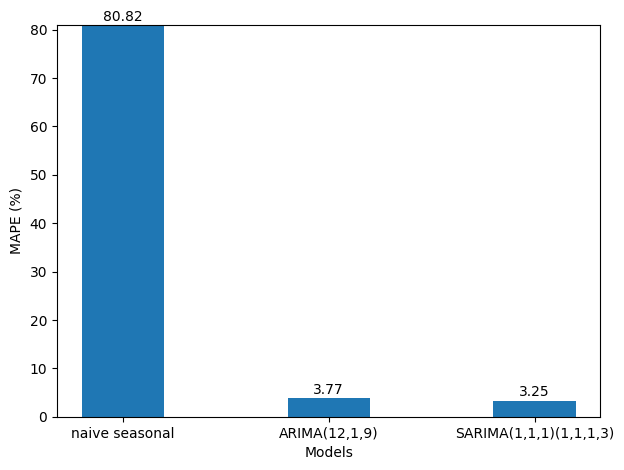

In [36]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(12,1,9)', 'SARIMA(1,1,1)(1,1,1,3)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 81)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

We have a MAPE of 3.25% for our SARIMA model which we can can considere as very good in terms of model accuracy. Such a low MAPE indicates that the model predictions are very close to the actual values of the time series even without passing the Ljungbox test.
So our best model is the SARIMA compared to the other two models.

### 10- Forecasting

Now that we now that our model is good, we can try to fit our model on every data of our dataset and make some prediction.

In [28]:
model = SARIMAX(df_two['LandAverageTemperature'], order=(0,3,0), simple_differencing=False)
model_fit = model.fit(disp=False)

In [29]:
prediction = SARIMA_model_fit.forecast(steps=36)

We create a prediction for 36 months which is equivalent to 3 years of prediction.

In [30]:
#creating a df with the predicted value and the corresponding year
dates = pd.date_range(start='2016-01', end='2019-01', freq='m')
df_predictions = pd.DataFrame({'LandAverageTemperature': prediction, 'dt': dates})
df_predictions['date'] = df_predictions['dt'].apply(lambda x: x.year)
df_predictions.drop('dt', axis=1, inplace=True)
df_predictions.head()

LandAverageTemperature  date
2016-01-01                3.951992  2016
2016-02-01                4.141638  2016
2016-03-01                6.484476  2016
2016-04-01                9.622840  2016
2016-05-01               12.337300  2016

We find here our predictions over the next 3 years for the evolution of temperatures in the world.

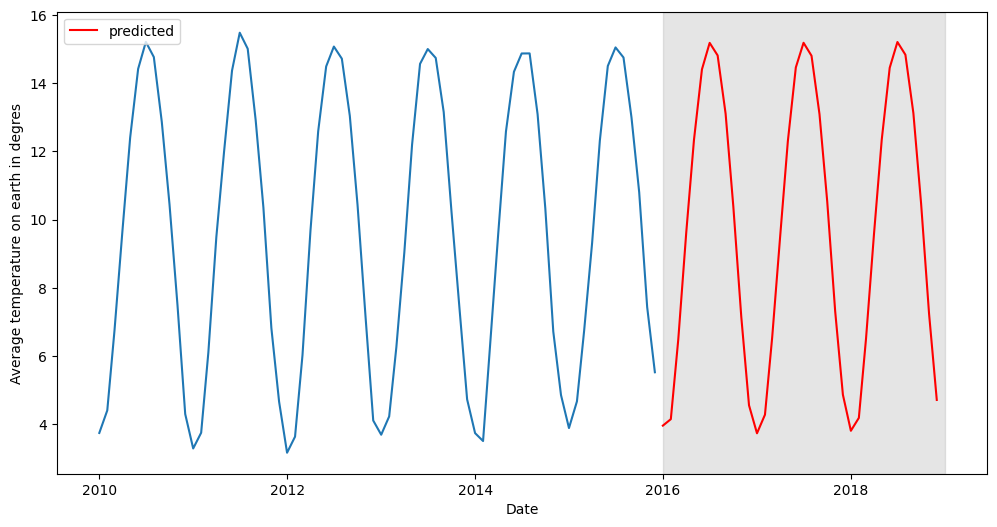

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(df_two.index, df_two['LandAverageTemperature'])
ax.plot(df_predictions.index, df_predictions['LandAverageTemperature'], 'r-', label='predicted')

ax.set_xlabel('Date')
ax.set_ylabel('Average temperature on earth in degres')
ax.axvspan('2016-01', '2019-01', color='#808080', alpha=0.2)


ax.legend(loc=2)

num_ticks = 8
locator = mdates.AutoDateLocator(minticks=num_ticks, maxticks=num_ticks)
ax.xaxis.set_major_locator(locator)

On this graph, we find a prediction for the next 3 years from 2016. We don't show any date in the forcasting space of our graph because no datas are presents for 2016 year in our dataSet. We can observe that our predictions follow the same patern as other year and keep the slow augmentation on an entire cycle.

The trend of our graph seems to depend on the seasons/months of each year.
Our prediction can be seen as very alarming given the fact that if our greenhouse emissions continue to grow exponentially in the next few years, we could see a greater increase in global temperatures.

## Conclusion

---

In conclusion, the SARIMA model provides accurate predictions of monthly electricity consumption for the next 36 months. The forecasted values follow the observed trends in the data and reflect the continuous increase in consumption observed over the years. The visual representation of forecasts in the graph helps to understand the expected development of climate change in the world on earth and can be used as a basis for decision-making in the world in order to be able to stem global warming and to be able to create awareness populations of the need to drastically reduce our greenhouse gas emissions in the years to come.